In [0]:
# Load basic library
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import random
from sklearn.externals import joblib 
from scipy import stats
import itertools

# Load Keras
from keras.models import Sequential, Model
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2
from keras.layers import Dropout

#Load sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

from sklearn.metrics import log_loss 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score,balanced_accuracy_score
from sklearn.metrics import average_precision_score 

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF

#ML normal ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#ML ensembles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

#Special
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

#Load visual neural:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# import require packages for plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import altair as alt # no need to add altviewer
from pandas.plotting import scatter_matrix


In [0]:
# To make the output stable across runs
'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

tf.random.set_seed(42)
np.random.seed(42)

In [0]:
# Load the data
file='https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv'
data = pd.read_csv(file)

In [0]:
dataX = data.drop(['Class','Time'],axis=1)
dataY = data['Class']

In [118]:
print(dataX.shape)
print(dataY.shape)

(284807, 29)
(284807,)


In [0]:
# Scale data
featuresToScale = dataX.columns
sX = StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.3, 
                                       random_state=2018, stratify=dataY)

In [121]:
print([x.shape for x in (X_train, X_test, y_train, y_test)])

[(199364, 29), (85443, 29), (199364,), (85443,)]


In [122]:
print(X_train.shape)
print(X_test.shape)

(199364, 29)
(85443, 29)


### Drop 90% of the labels from the training set

As before, we will generate a training and test set. But we will drop 90% of the fraudulent credit card transactions from the training set to simulate how to work with partially labeled datasets. While this may seem like a very aggressive move, real-world problems involving payment fraud have similarly low incidences of fraud (as little as 1 fraud per 10,000 cases). By removing 90% of the labels from the training set, we are simulating this type of phenomenon:

In [123]:
X_train.shape

(199364, 29)

In [124]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

In [125]:
y_test.value_counts()

0    85295
1      148
Name: Class, dtype: int64

In [126]:
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
X_train.shape

(199054, 29)

In [128]:
y_train.value_counts()

0    199020
1        34
Name: Class, dtype: int64

In [0]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [0]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    average_precision = average_precision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

# Supervised Model

In [0]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [0]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [133]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, 
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):

    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],   y_train.iloc[cv_index]
    # X_cv and y_cv : for validation
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    # same as deep learning ?
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, 
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(
        X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)

[1]	valid_0's binary_logloss: 0.00321986
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00317819
[3]	valid_0's binary_logloss: 0.00255191
[4]	valid_0's binary_logloss: 0.0028994
[5]	valid_0's binary_logloss: 0.00201755
[6]	valid_0's binary_logloss: 0.0020024
[7]	valid_0's binary_logloss: 0.00198964
[8]	valid_0's binary_logloss: 0.00197891
[9]	valid_0's binary_logloss: 0.00196711
[10]	valid_0's binary_logloss: 0.0019539
[11]	valid_0's binary_logloss: 0.00194175
[12]	valid_0's binary_logloss: 0.00192937
[13]	valid_0's binary_logloss: 0.001918
[14]	valid_0's binary_logloss: 0.00190637
[15]	valid_0's binary_logloss: 0.00189581
[16]	valid_0's binary_logloss: 0.00188551
[17]	valid_0's binary_logloss: 0.00187701
[18]	valid_0's binary_logloss: 0.00186782
[19]	valid_0's binary_logloss: 0.0018573
[20]	valid_0's binary_logloss: 0.00184705
[21]	valid_0's binary_logloss: 0.00183708
[22]	valid_0's binary_logloss: 0.00182733
[23]	valid_0's binary_loglos

In [134]:
    print(f'Training Log Loss: {loglossTraining}')
    print(f'CV Log Loss: {loglossCV}')

Training Log Loss: 1.4686494946021322e-05
CV Log Loss: 0.0020357818318726914


In [135]:
predictionsBasedOnKFolds

,prediction
252400,1.54964e-05
171895,1.80791e-07
135426,3.2212e-07
178814,1.75357e-05
129784,1.6304e-07
...,...
195475,0.000166192
48687,0.000166192
159608,0.000166192
205176,1.61202e-07


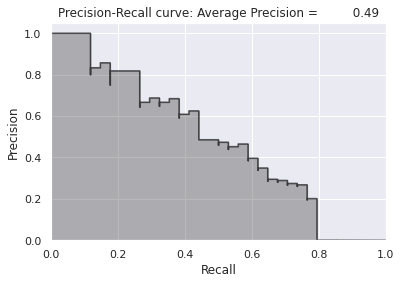

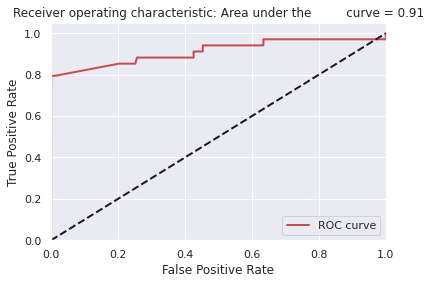

In [136]:
preds, average_precision = plotResults(y_train, 
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

In [137]:
predictionsBasedOnKFolds.loc[predictionsBasedOnKFolds['prediction']<0.5,'pred']=0
predictionsBasedOnKFolds.loc[predictionsBasedOnKFolds['prediction']>=0.5,'pred']=1
predictionsBasedOnKFolds

,prediction,pred
252400,1.54964e-05,0.0
171895,1.80791e-07,0.0
135426,3.2212e-07,0.0
178814,1.75357e-05,0.0
129784,1.6304e-07,0.0
...,...,...
195475,0.000166192,0.0
48687,0.000166192,0.0
159608,0.000166192,0.0
205176,1.61202e-07,0.0


In [138]:
confmat = confusion_matrix(y_train,predictionsBasedOnKFolds['pred'])
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train,predictionsBasedOnKFolds['pred']))

confusion_matrix 
 [[199001     19]
 [    17     17]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.47      0.50      0.49        34

    accuracy                           1.00    199054
   macro avg       0.74      0.75      0.74    199054
weighted avg       1.00      1.00      1.00    199054



In [139]:
predictions = pd.Series(data=gbm.predict(X_test, 
                num_iteration=gbm.best_iteration), index=X_test.index)
predictions

254955    5.748703e-07
167022    6.086779e-07
32334     8.335931e-07
178244    5.862316e-07
72474     6.093036e-07
              ...     
264857    2.038976e-04
49388     5.849867e-07
254155    1.182768e-05
64966     1.558072e-06
124398    5.174026e-07
Length: 85443, dtype: float64

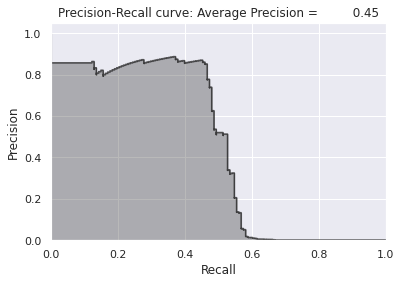

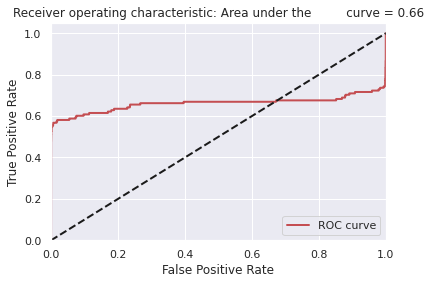

In [140]:
preds, average_precision = plotResults(y_test, predictions, True)

In [141]:
prediction_test_df=pd.DataFrame(predictions)
prediction_test_df.loc[prediction_test_df[0]<0.5,'pred']=0
prediction_test_df.loc[prediction_test_df[0]>=0.5,'pred']=1
prediction_test_df

,0,pred
254955,5.748703e-07,0.0
167022,6.086779e-07,0.0
32334,8.335931e-07,0.0
178244,5.862316e-07,0.0
72474,6.093036e-07,0.0
...,...,...
264857,2.038976e-04,0.0
49388,5.849867e-07,0.0
254155,1.182768e-05,0.0
64966,1.558072e-06,0.0


In [142]:
prediction_test_df['pred'].value_counts()

0.0    85361
1.0       82
Name: pred, dtype: int64

In [143]:
y_test.value_counts()

0    85295
1      148
Name: Class, dtype: int64

In [144]:
confmat = confusion_matrix(y_test,prediction_test_df['pred'])
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test,prediction_test_df['pred']))

confusion_matrix 
 [[85282    13]
 [   79    69]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.84      0.47      0.60       148

    accuracy                           1.00     85443
   macro avg       0.92      0.73      0.80     85443
weighted avg       1.00      1.00      1.00     85443



# Unsupervised Model

Take the 33 fraudulent cases, duplicate these 100 times and then append them to the training set

In [0]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [146]:
X_train.shape, y_train.shape

((202454, 29), (202454,))

In [147]:
X_train_original.shape,y_train_original.shape

((199054, 29), (199054,))

In [148]:
y_train_original.value_counts()

0    199020
1        34
Name: Class, dtype: int64

In [149]:
y_train.value_counts()

0    199020
1      3434
Name: Class, dtype: int64

A sparse two-layer overcomplete autoencoder with a linear a linear activation function.
Forty nodes in the hidden layer and a dropout of 2%

In [150]:
model = Sequential()
model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(1e-4),
                input_dim=29, name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 40)                1200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 29)                1189      
Total params: 2,389
Trainable params: 2,389
Non-trainable params: 0
_________________________________________________________________


In [151]:
num_epochs =  5
batch_size = 32

history = model.fit(x=X_train, y=X_train, epochs=num_epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.20, verbose=1)

Train on 161963 samples, validate on 40491 samples
Epoch 1/5
161963/161963 [==============================] - 7s 41us/step - loss: 0.1355 - accuracy: 0.8695 - val_loss: 0.0765 - val_accuracy: 0.9840
Epoch 2/5
161963/161963 [==============================] - 7s 41us/step - loss: 0.0536 - accuracy: 0.9260 - val_loss: 0.2349 - val_accuracy: 0.9706
Epoch 3/5
161963/161963 [==============================] - 7s 41us/step - loss: 0.0451 - accuracy: 0.9257 - val_loss: 0.0670 - val_accuracy: 0.9672
Epoch 4/5
161963/161963 [==============================] - 7s 41us/step - loss: 0.0399 - accuracy: 0.9253 - val_loss: 0.0470 - val_accuracy: 0.9830
Epoch 5/5
161963/161963 [==============================] - 7s 41us/step - loss: 0.0383 - accuracy: 0.9226 - val_loss: 0.2640 - val_accuracy: 0.8846


In [152]:
y_train.value_counts()

0    199020
1      3434
Name: Class, dtype: int64

In [153]:
y_train_original.value_counts()

0    199020
1        34
Name: Class, dtype: int64

199054/199054 [==============================] - 3s 14us/step


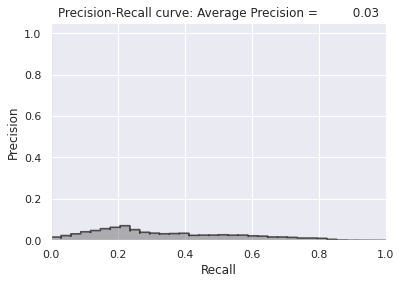

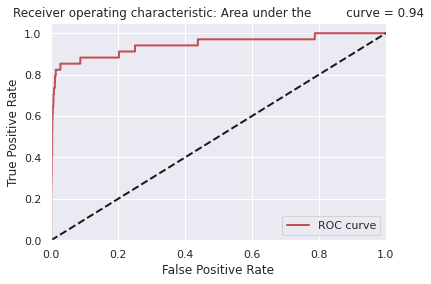

In [154]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, anomalyScoresAETrain, True)

In [155]:
best_threshold=0.5 # Normal threshold if not tunning
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresAETrain]
confmat = confusion_matrix(y_train_original,y_pred_new)
print('accuracy_score: \n',accuracy_score(y_train_original, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train_original, y_pred_new))

accuracy_score: 
 0.9998241683161353
confusion_matrix 
 [[199019      1]
 [    34      0]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.00      0.00      0.00        34

    accuracy                           1.00    199054
   macro avg       0.50      0.50      0.50    199054
weighted avg       1.00      1.00      1.00    199054



Tunning threshold follow precesion-recall

Best Threshold=0.011392, F-Score=nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.03')

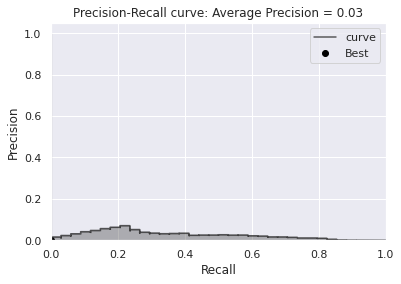

In [156]:
precision, recall, thresholds = precision_recall_curve(y_train_original,anomalyScoresAETrain)
average_precision = average_precision_score(y_train_original,anomalyScoresAETrain)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold=thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (best_threshold, fscore[ix]))

# plot the roc curve for the model
plt.step(recall, precision, color='k', alpha=0.7, where='post',label='curve')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

Best Threshold=0.000085


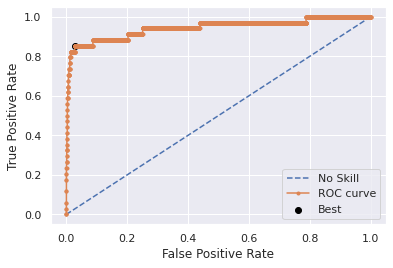

In [157]:
fpr, tpr, thresholds = roc_curve(y_train_original,anomalyScoresAETrain)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ROC curve')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [158]:
best_threshold=best_thresh 
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresAETrain]
confmat = confusion_matrix(y_train_original,y_pred_new)
print('accuracy_score: \n',accuracy_score(y_train_original, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train_original, y_pred_new))

accuracy_score: 
 0.9722085464245883
confusion_matrix 
 [[193493   5527]
 [     5     29]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    199020
           1       0.01      0.85      0.01        34

    accuracy                           0.97    199054
   macro avg       0.50      0.91      0.50    199054
weighted avg       1.00      0.97      0.99    199054



Evaluate test set

85443/85443 [==============================] - 1s 14us/step


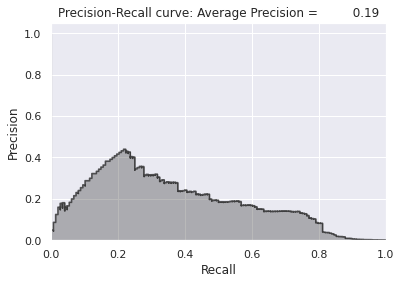

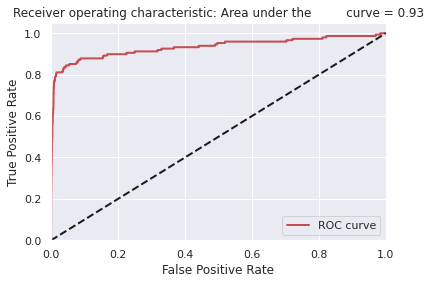

In [159]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [160]:
best_threshold=0.5 # Normal threshold if not tunning
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresAE]
confmat = confusion_matrix(y_test,y_pred_new)
print('accuracy_score: \n',accuracy_score(y_test, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test, y_pred_new))

accuracy_score: 
 0.9982444436641972
confusion_matrix 
 [[85293     2]
 [  148     0]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



In [161]:
best_threshold=best_thresh # Tunning threshold from training set AUC curver
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresAE]
confmat = confusion_matrix(y_test,y_pred_new)
print('accuracy_score: \n',accuracy_score(y_test, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test, y_pred_new))

accuracy_score: 
 0.7949978348138526
confusion_matrix 
 [[67794 17501]
 [   15   133]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      0.79      0.89     85295
           1       0.01      0.90      0.01       148

    accuracy                           0.79     85443
   macro avg       0.50      0.85      0.45     85443
weighted avg       1.00      0.79      0.88     85443



# Semisupervised Model

In [162]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 40)                1200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 29)                1189      
Total params: 2,389
Trainable params: 2,389
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Model from auto encoder will be used to transform X_train and X_test.
layer_name = 'hidden_layer'
intermediate_layer_model  = Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)

In [164]:
intermediate_layer_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_input (InputLay (None, 29)                0         
_________________________________________________________________
hidden_layer (Dense)         (None, 40)                1200      
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________


In [0]:
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test  = intermediate_layer_model.predict(X_test_original)

In [166]:
intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF  = pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)
intermediate_output_trainDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
252400,-0.065959,0.081779,0.004650,-0.072177,0.067172,-0.055681,-0.006946,-0.303490,0.060674,-0.002682,0.175451,-0.033876,0.040021,-0.001969,0.114253,-0.053580,0.051835,0.020700,-0.149962,0.030587,-0.015808,0.025309,-0.126205,0.165493,-0.011823,0.077071,0.056403,-0.002936,0.017063,0.054772,0.013896,-0.345763,0.017363,-0.118094,0.015230,0.026653,-0.089755,0.106573,0.042753,-0.077431
171895,0.090503,-0.008125,0.055176,-0.354311,0.124006,0.004035,0.011565,-0.202474,0.184930,0.043074,-0.125341,-0.224637,-0.281153,-0.297592,-0.013285,0.063960,0.207202,-0.098199,-0.125968,-0.175395,-0.013140,0.136583,-0.237084,0.005183,0.221895,-0.265243,0.092071,-0.065711,0.639394,-0.272573,-0.072157,0.194441,0.022181,0.045046,0.076943,-0.241552,0.114115,-0.044694,0.141701,0.334901
135426,0.462330,0.058065,-0.161015,-0.014031,-0.296847,-0.398367,-0.015786,-0.147394,-0.398147,0.081024,-0.111959,0.360089,0.045732,0.096347,-0.074056,0.051931,0.115108,0.114331,-0.167642,0.389126,0.014947,-0.267782,-0.010074,0.244072,0.175442,-0.029128,0.207249,0.098325,-0.141874,-0.122759,0.121968,0.252158,-0.254499,0.138877,0.287189,0.038559,-0.119644,-0.123750,-0.090341,-0.182892
178814,-0.544557,0.316420,-0.702381,0.760445,-0.021712,0.610073,-0.707259,0.145592,1.358253,-0.175099,-0.644828,1.197483,-0.187671,1.549375,-1.105075,0.259168,0.568207,0.071512,0.519485,0.304957,0.645771,0.683727,-1.254840,1.338631,-0.806883,-0.252399,-0.321792,-1.147236,0.335550,-1.677909,-1.667927,-0.903324,-0.345075,-0.545715,-1.386204,-0.597581,0.254432,2.237433,0.442266,0.408379
129784,-0.290733,0.101970,0.084263,0.144494,0.144964,0.034281,0.019995,-0.276906,-0.078673,0.094258,-0.219144,-0.112651,-0.017070,-0.090146,-0.252355,0.144944,0.222216,0.111824,0.095283,0.230566,-0.075162,0.025917,0.092997,0.029662,0.028506,0.018150,0.016763,-0.145603,0.002113,-0.052061,-0.049867,-0.226974,0.173635,-0.008326,0.299735,0.309377,0.237202,-0.235261,0.153869,0.178385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195475,0.902497,-0.006940,0.049207,-0.410927,0.051319,0.072598,0.468165,0.687264,0.453925,-0.022982,0.018337,-0.042214,-0.266591,-0.105951,-0.083837,-0.004164,-0.081312,0.543706,0.292703,-0.839784,0.136649,0.116123,0.136829,-1.027877,-0.278395,0.165279,0.244920,-0.175403,0.294378,-0.285599,0.568893,-0.370772,0.026891,-0.274573,-0.097527,-0.039968,-0.015843,-0.088094,-0.333574,0.702682
48687,0.451491,-0.021289,0.089915,-0.103640,0.176252,0.105799,0.001502,0.267414,0.314278,0.190034,0.061227,-0.077759,-0.096592,-0.087660,-0.027489,0.182066,-0.095922,0.292516,0.127444,-0.298433,-0.066822,0.171417,-0.188457,-0.377432,-0.331647,0.092157,0.184080,-0.214484,0.158108,-0.067165,0.245869,-0.342244,0.018823,-0.338260,0.021567,0.048375,-0.225132,-0.048190,-0.139287,0.113243
159608,-0.116712,0.027260,-0.014552,0.110797,-0.069237,-0.075661,-0.059893,0.037155,-0.021456,0.153007,0.034451,0.000706,0.094124,-0.055060,0.128349,0.074459,-0.098448,0.020426,-0.045722,-0.071417,-0.224822,-0.119630,-0.136268,0.162292,0.014927,-0.021030,0.006908,-0.081635,-0.101563,0.022683,-0.089582,-0.302602,0.064834,-0.031263,-0.089649,-0.255167,-0.282351,0.215967,0.121157,-0.534035
205176,0.820060,0.564959,-0.019242,-0.714736,0.157897,-0.045934,-0.029480,0.852031,0.436076,-0.042823,0.079055,0.208848,-0.185523,-0.196765,-0.151562,0.158400,-0.049357,0.884855,0.081580,-0.526396,-0.119107,-0.239921,0.589929,-1.123639,-0.495264,0.298373,0.639817,-0.222492,0.075279,-0.105977,0.800335,-0.525878,-0.015109,-0.549337,0.030659,-0.199615,0.216406,-0.004258,-0.129356,0.624304


In [167]:
X_train_original

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
252400,1.055295,-0.010751,-0.712706,0.280704,-0.052213,-0.876401,0.173987,-0.299533,0.432059,0.054741,-0.701580,0.668497,0.546831,0.186007,-0.007643,-0.124704,-0.397095,-1.082294,0.204109,-0.249506,-0.391982,-0.925970,0.523618,-0.018828,-0.526180,0.410968,-0.167836,-0.180421,-0.346073
171895,1.006053,-0.460619,-1.102435,-0.450387,1.206518,2.947251,-1.054417,0.886446,1.010886,0.021803,-0.212471,0.371379,-0.022406,-0.064894,0.837898,0.278774,-0.667545,-0.152528,-0.483115,-0.143639,0.218307,0.777441,0.324419,1.254516,-0.470548,1.221701,-0.000626,-0.160412,-0.307251
135426,-0.731099,0.317777,1.725704,1.881673,-0.126631,1.265325,-0.524671,0.918829,-0.545192,-0.235698,-0.033822,1.327641,0.396111,-0.605414,-2.764306,-0.566119,0.732276,-0.415015,0.899800,0.137483,-0.117981,-0.238605,-0.246468,-0.439275,0.440789,0.209601,0.015633,-0.168490,-0.204221
178814,-4.021913,-3.869072,-2.318957,0.695530,4.534704,-2.697238,-1.210103,-4.343034,1.389733,0.846635,-1.738247,0.065600,-0.126018,0.410346,-0.094308,0.173249,-1.086759,-0.440417,0.795971,-9.423919,2.901720,1.381553,4.959889,-1.353827,0.896515,-0.270573,7.598828,-1.499358,-0.349231
129784,0.615128,-0.170915,0.603772,-0.558176,-0.639049,-0.238178,-0.438886,0.012891,1.436250,-1.074956,0.051944,1.669866,1.529781,-0.454359,1.475277,-0.923573,0.050725,-0.543486,0.229564,-0.072717,0.045605,0.631666,-0.040258,0.233515,0.922587,-1.373199,0.298497,0.106900,-0.349231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195475,-0.254091,-2.756705,-2.082848,0.720192,-0.770847,0.043816,1.347183,-0.309383,0.281819,-0.211026,0.278861,-0.328197,-1.635081,1.323811,0.420262,0.750262,-0.892042,1.073540,-0.213397,3.172416,1.379262,-0.221650,-1.822138,0.611275,-0.865244,1.296414,-0.902976,0.455664,5.005845
48687,0.106034,-1.131050,-0.470366,0.156445,-0.553642,-0.376423,0.654146,-0.283678,0.204805,-0.432029,-0.958501,-0.121456,0.113733,0.415596,1.318948,0.622449,-0.634298,-0.288609,0.361196,1.498658,0.098597,-1.586216,-0.825029,-0.620769,0.109427,1.733472,-0.501687,0.300189,2.041624
159608,0.055698,0.496830,-0.098914,-0.582971,0.647489,-0.393782,0.810516,-0.116346,0.031466,-0.378264,-1.829348,-0.240612,0.130288,0.065815,-0.349600,0.244105,-0.922168,-0.476713,0.377217,0.002229,-0.444765,-1.058758,-0.074376,-1.672445,-0.672678,0.420560,0.603711,0.263881,-0.320925
205176,-0.465058,-3.687667,-1.636115,0.318007,-1.776144,0.183209,0.938757,-0.339245,0.094134,-0.073328,-1.164315,-0.760336,-0.441810,-0.010425,-0.121710,1.430958,0.448079,-1.579909,0.610219,4.132933,0.991049,-2.119530,-1.541746,0.986901,-2.016554,-1.584039,-0.753628,0.722995,6.086088


In [0]:
# Merger 40 column X_train transform with 29 column X_train_original with the same index
X_train = X_train_original.merge(intermediate_output_trainDF, left_index=True,right_index=True)
X_test  = X_test_original.merge(intermediate_output_testDF, left_index=True,right_index=True)
y_train = y_train_original.copy() # Not change

In [169]:
print(X_train_original.shape)
print(X_test_original.shape)

(199054, 29)
(85443, 29)


In [170]:
print(X_train.shape)
print(X_test.shape)
y_train.value_counts()

(199054, 69)
(85443, 69)


0    199020
1        34
Name: Class, dtype: int64

In [171]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
252400,1.055295,-0.010751,-0.712706,0.280704,-0.052213,-0.876401,0.173987,-0.299533,0.432059,0.054741,-0.701580,0.668497,0.546831,0.186007,-0.007643,-0.124704,-0.397095,-1.082294,0.204109,-0.249506,-0.391982,-0.925970,0.523618,-0.018828,-0.526180,0.410968,-0.167836,-0.180421,-0.346073,-0.065959,0.081779,0.004650,-0.072177,0.067172,-0.055681,-0.006946,-0.303490,0.060674,-0.002682,0.175451,-0.033876,0.040021,-0.001969,0.114253,-0.053580,0.051835,0.020700,-0.149962,0.030587,-0.015808,0.025309,-0.126205,0.165493,-0.011823,0.077071,0.056403,-0.002936,0.017063,0.054772,0.013896,-0.345763,0.017363,-0.118094,0.015230,0.026653,-0.089755,0.106573,0.042753,-0.077431
171895,1.006053,-0.460619,-1.102435,-0.450387,1.206518,2.947251,-1.054417,0.886446,1.010886,0.021803,-0.212471,0.371379,-0.022406,-0.064894,0.837898,0.278774,-0.667545,-0.152528,-0.483115,-0.143639,0.218307,0.777441,0.324419,1.254516,-0.470548,1.221701,-0.000626,-0.160412,-0.307251,0.090503,-0.008125,0.055176,-0.354311,0.124006,0.004035,0.011565,-0.202474,0.184930,0.043074,-0.125341,-0.224637,-0.281153,-0.297592,-0.013285,0.063960,0.207202,-0.098199,-0.125968,-0.175395,-0.013140,0.136583,-0.237084,0.005183,0.221895,-0.265243,0.092071,-0.065711,0.639394,-0.272573,-0.072157,0.194441,0.022181,0.045046,0.076943,-0.241552,0.114115,-0.044694,0.141701,0.334901
135426,-0.731099,0.317777,1.725704,1.881673,-0.126631,1.265325,-0.524671,0.918829,-0.545192,-0.235698,-0.033822,1.327641,0.396111,-0.605414,-2.764306,-0.566119,0.732276,-0.415015,0.899800,0.137483,-0.117981,-0.238605,-0.246468,-0.439275,0.440789,0.209601,0.015633,-0.168490,-0.204221,0.462330,0.058065,-0.161015,-0.014031,-0.296847,-0.398367,-0.015786,-0.147394,-0.398147,0.081024,-0.111959,0.360089,0.045732,0.096347,-0.074056,0.051931,0.115108,0.114331,-0.167642,0.389126,0.014947,-0.267782,-0.010074,0.244072,0.175442,-0.029128,0.207249,0.098325,-0.141874,-0.122759,0.121968,0.252158,-0.254499,0.138877,0.287189,0.038559,-0.119644,-0.123750,-0.090341,-0.182892
178814,-4.021913,-3.869072,-2.318957,0.695530,4.534704,-2.697238,-1.210103,-4.343034,1.389733,0.846635,-1.738247,0.065600,-0.126018,0.410346,-0.094308,0.173249,-1.086759,-0.440417,0.795971,-9.423919,2.901720,1.381553,4.959889,-1.353827,0.896515,-0.270573,7.598828,-1.499358,-0.349231,-0.544557,0.316420,-0.702381,0.760445,-0.021712,0.610073,-0.707259,0.145592,1.358253,-0.175099,-0.644828,1.197483,-0.187671,1.549375,-1.105075,0.259168,0.568207,0.071512,0.519485,0.304957,0.645771,0.683727,-1.254840,1.338631,-0.806883,-0.252399,-0.321792,-1.147236,0.335550,-1.677909,-1.667927,-0.903324,-0.345075,-0.545715,-1.386204,-0.597581,0.254432,2.237433,0.442266,0.408379
129784,0.615128,-0.170915,0.603772,-0.558176,-0.639049,-0.238178,-0.438886,0.012891,1.436250,-1.074956,0.051944,1.669866,1.529781,-0.454359,1.475277,-0.923573,0.050725,-0.543486,0.229564,-0.072717,0.045605,0.631666,-0.040258,0.233515,0.922587,-1.373199,0.298497,0.106900,-0.349231,-0.290733,0.101970,0.084263,0.144494,0.144964,0.034281,0.019995,-0.276906,-0.078673,0.094258,-0.219144,-0.112651,-0.017070,-0.090146,-0.252355,0.144944,0.222216,0.111824,0.095283,0.230566,-0.075162,0.025917,0.092997,0.029662,0.028506,0.018150,0.016763,-0.145603,0.002113,-0.052061,-0.049867,-0.226974,0.173635,-0.008326,0.299735,0.309377,0.237202,-0.235261,0.153869,0.178385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195475,-0.254091,-2.756705,-2.082848,0.720192,-0.770847,0.043816,1.347183,-0.309383,0.281819,-0.211026,0.278861,-0.328197,-1.635081,1.323811,0.420262,0.750262,-0.892042,1.073540,-0.213397,3

In [172]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,  columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold,num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
 

[1]	valid_0's binary_logloss: 0.00268261
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00272223
[3]	valid_0's binary_logloss: 0.00280242
[4]	valid_0's binary_logloss: 0.00274147
[5]	valid_0's binary_logloss: 0.00255115
[6]	valid_0's binary_logloss: 0.0022974
[7]	valid_0's binary_logloss: 0.00203893
[8]	valid_0's binary_logloss: 0.00203021
[9]	valid_0's binary_logloss: 0.00202198
[10]	valid_0's binary_logloss: 0.0020142
[11]	valid_0's binary_logloss: 0.00200676
[12]	valid_0's binary_logloss: 0.00199969
[13]	valid_0's binary_logloss: 0.00199302
[14]	valid_0's binary_logloss: 0.00198452
[15]	valid_0's binary_logloss: 0.00197672
[16]	valid_0's binary_logloss: 0.00196812
[17]	valid_0's binary_logloss: 0.0019607
[18]	valid_0's binary_logloss: 0.00195359
[19]	valid_0's binary_logloss: 0.00194679
[20]	valid_0's binary_logloss: 0.00194025
[21]	valid_0's binary_logloss: 0.00193405
[22]	valid_0's binary_logloss: 0.00192796
[23]	valid_0's binary_log

In [173]:
print(f'Training Log Loss: {round(loglossTraining,4)}')
print(f'CV Log Loss: {round(loglossCV,4)}' )

Training Log Loss: 0.0013
CV Log Loss: 0.0016


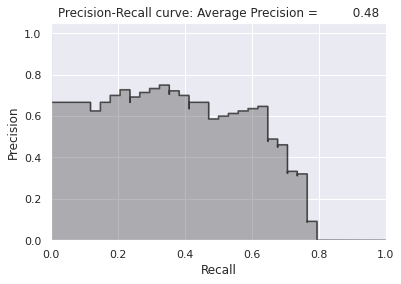

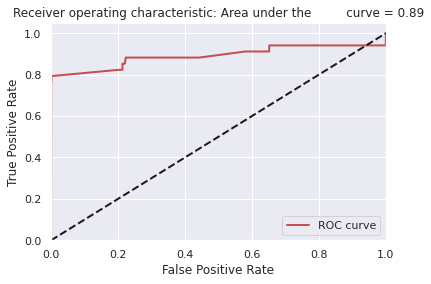

In [174]:
preds, average_precision = plotResults(y_train, 
                                       predictionsBasedOnKFolds.loc[:,'prediction'], True)

In [0]:
predictionsBasedOnKFolds.loc[predictionsBasedOnKFolds['prediction']<0.5,'pred']=0
predictionsBasedOnKFolds.loc[predictionsBasedOnKFolds['prediction']>=0.5,'pred']=1
#predictionsBasedOnKFolds

In [176]:
confmat = confusion_matrix(y_train,predictionsBasedOnKFolds['pred'])
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train,predictionsBasedOnKFolds['pred']))

confusion_matrix 
 [[199008     12]
 [    13     21]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.64      0.62      0.63        34

    accuracy                           1.00    199054
   macro avg       0.82      0.81      0.81    199054
weighted avg       1.00      1.00      1.00    199054



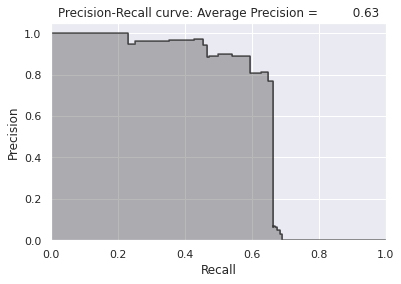

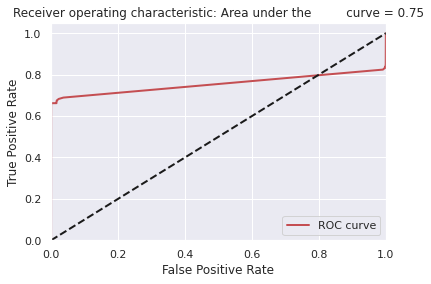

In [177]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [0]:
prediction_test_df=pd.DataFrame(predictions)
prediction_test_df.loc[prediction_test_df[0]<0.5,'pred']=0
prediction_test_df.loc[prediction_test_df[0]>=0.5,'pred']=1
#prediction_test_df

In [179]:
confmat = confusion_matrix(y_test,prediction_test_df['pred'])
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test,prediction_test_df['pred']))

confusion_matrix 
 [[85273    22]
 [   55    93]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.81      0.63      0.71       148

    accuracy                           1.00     85443
   macro avg       0.90      0.81      0.85     85443
weighted avg       1.00      1.00      1.00     85443



# Feature important

In [180]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', ascending=False,inplace=True)
featuresImportance

,featImportance
V1,0.14
V21,0.08
22,0.06
8,0.06
Amount,0.06
...,...
7,0.00
V6,0.00
9,0.00
10,0.00


As you can see here, some of the top features are features the hidden layer learned by the autoencoder (the non “V” features) while others are the principal components from the original dataset (the “V” features) as well as the amount of the transaction.

# Semisupervised Model 2

In [0]:
intermediate_output_train = model.predict(X_train_original)
intermediate_output_test  = model.predict(X_test_original)
intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF  = pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [183]:
intermediate_output_testDF.shape # 29 instead 40 columns

(85443, 29)

In [0]:
# Merger 29 column X_train transform with 29 column X_train_original with the same index
X_train = X_train_original.merge(intermediate_output_trainDF, left_index=True,right_index=True)
X_test  = X_test_original.merge(intermediate_output_testDF, left_index=True,right_index=True)
y_train = y_train_original.copy() # Not change

In [185]:
X_train.shape

(199054, 58)

In [186]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,  columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold,num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    #print(f'Training Log Loss: {round(loglossTraining,4)}')
    #print(f'CV Log Loss: {round(loglossCV,4)}' )

[1]	valid_0's binary_logloss: 0.00284218
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00304294
[3]	valid_0's binary_logloss: 0.00302299
[4]	valid_0's binary_logloss: 0.0031598
[5]	valid_0's binary_logloss: 0.00605329
[6]	valid_0's binary_logloss: 0.00591516
[7]	valid_0's binary_logloss: 0.00497581
[8]	valid_0's binary_logloss: 0.00471333
[9]	valid_0's binary_logloss: 0.00463425
[10]	valid_0's binary_logloss: 0.00458804
[11]	valid_0's binary_logloss: 0.00430158
[12]	valid_0's binary_logloss: 0.0040792
[13]	valid_0's binary_logloss: 0.0040717
[14]	valid_0's binary_logloss: 0.00408081
[15]	valid_0's binary_logloss: 0.00415854
[16]	valid_0's binary_logloss: 0.00439341
[17]	valid_0's binary_logloss: 0.00459681
[18]	valid_0's binary_logloss: 0.00480056
[19]	valid_0's binary_logloss: 0.00479298
[20]	valid_0's binary_logloss: 0.00478594
[21]	valid_0's binary_logloss: 0.00478004
[22]	valid_0's binary_logloss: 0.00477417
[23]	valid_0's binary_log

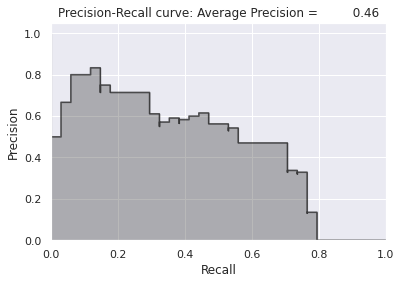

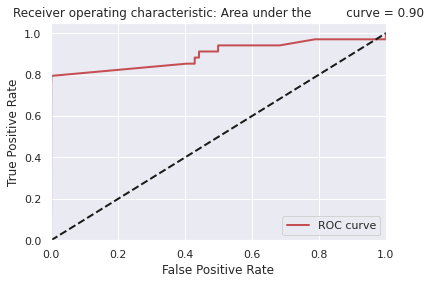

In [187]:
preds, average_precision = plotResults(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

In [189]:
predictionsBasedOnKFolds.loc[predictionsBasedOnKFolds['prediction']<0.5,'pred']=0
predictionsBasedOnKFolds.loc[predictionsBasedOnKFolds['prediction']>=0.5,'pred']=1
confmat = confusion_matrix(y_train,predictionsBasedOnKFolds['pred'])
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train,predictionsBasedOnKFolds['pred']))

confusion_matrix 
 [[198993     27]
 [    10     24]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.47      0.71      0.56        34

    accuracy                           1.00    199054
   macro avg       0.74      0.85      0.78    199054
weighted avg       1.00      1.00      1.00    199054



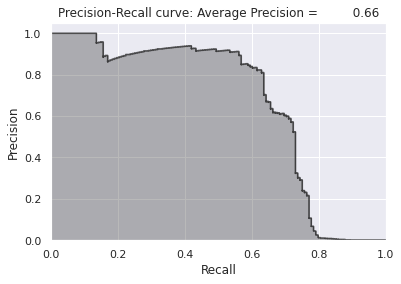

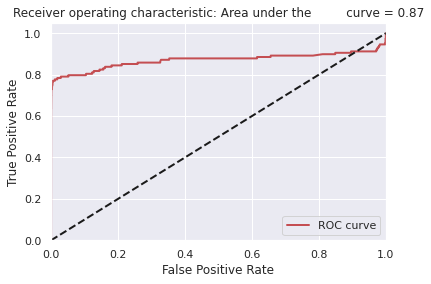

In [188]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [190]:
prediction_test_df=pd.DataFrame(predictions)
prediction_test_df.loc[prediction_test_df[0]<0.5,'pred']=0
prediction_test_df.loc[prediction_test_df[0]>=0.5,'pred']=1
confmat = confusion_matrix(y_test,prediction_test_df['pred'])
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test,prediction_test_df['pred']))

confusion_matrix 
 [[85289     6]
 [   76    72]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.49      0.64       148

    accuracy                           1.00     85443
   macro avg       0.96      0.74      0.82     85443
weighted avg       1.00      1.00      1.00     85443



In [191]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', ascending=False,inplace=True)
featuresImportance

,featImportance
Amount,0.077452
28,0.056305
V16,0.051018
V23,0.043087
V26,0.039651
V13,0.039387
V11,0.037008
3,0.035950
V6,0.034893
V1,0.034629
